In [1]:
!pip install --quiet pillow matplotlib torchvision


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [13]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np

class OxfordPetsMultiClassDataset(Dataset):
    """
    Мультиклассовый датасет Oxford Pets.
    Маски: 1=фон, 2=кошки, 3=собаки → 0,1,2
    """

    def __init__(self, root, joint_transform=None, image_transform=None):
        self.root = root
        self.image_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "annotations", "trimaps")

        images = [f for f in os.listdir(self.image_dir) if f.lower().endswith(".jpg")]
        masks = {os.path.splitext(f)[0]: f for f in os.listdir(self.mask_dir)}

        self.images = []
        self.masks = []
        for img in images:
            name = os.path.splitext(img)[0]
            if name in masks:
                self.images.append(img)
                self.masks.append(masks[name])

        self.images.sort()
        self.masks.sort()

        self.joint_transform = joint_transform
        self.image_transform = image_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(
            os.path.join(self.image_dir, self.images[idx])
        ).convert("RGB")

        mask = Image.open(
            os.path.join(self.mask_dir, self.masks[idx])
        )

        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)

        if self.image_transform:
            image = self.image_transform(image)

        mask = torch.from_numpy(np.array(mask)).long()

        # original: 1=bg, 2=pet, 3=border
        mask = mask - 1  # -> 0,1,2

        # border -> ignore
        mask[mask == 2] = 255

        mask[mask < 0] = 255
        mask[mask > 1] = 255

        return image, mask

In [3]:
import os
import tarfile
import urllib.request

DATA_ROOT = "oxford_pets"
IMAGES_DIR = os.path.join(DATA_ROOT, "images")
ANN_DIR = os.path.join(DATA_ROOT, "annotations")

os.makedirs(DATA_ROOT, exist_ok=True)

IMAGES_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
ANN_URL = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"


def download_and_extract(url, extract_to):
    filename = url.split("/")[-1]
    archive_path = os.path.join(extract_to, filename)

    if os.path.exists(os.path.join(extract_to, filename.replace(".tar.gz", ""))):
        print(f"{filename} already extracted, skipping.")
        return

    if not os.path.exists(archive_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, archive_path)

    print(f"Extracting {filename}...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(extract_to)


download_and_extract(IMAGES_URL, DATA_ROOT)
download_and_extract(ANN_URL, DATA_ROOT)

Extracting images.tar.gz...


/var/folders/bk/q068pvpx5979b18kqck5n23r0000gn/T/ipykernel_3724/2871311736.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_to)


Extracting annotations.tar.gz...


In [14]:
import random
import torchvision.transforms.functional as TF

class JointTransform:
    def __init__(self, size=(256, 256), augment=True):
        self.size = size
        self.augment = augment

    def __call__(self, image, mask):
        # Resize (всегда)
        image = TF.resize(image, self.size)
        mask = TF.resize(mask, self.size, interpolation=TF.InterpolationMode.NEAREST)

        if self.augment:
            # Horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)

            # Random rotation
            angle = random.uniform(-15, 15)
            image = TF.rotate(image, angle)
            mask = TF.rotate(
                mask,
                angle,
                interpolation=TF.InterpolationMode.NEAREST
            )

        return image, mask

In [15]:
image_only_transform = T.Compose([
    T.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    T.ToTensor(),
])

In [16]:
root = "oxford_pets"

joint_transform_train = JointTransform(size=(256, 256), augment=True)
joint_transform_val = JointTransform(size=(256, 256), augment=False)

train_dataset = OxfordPetsMultiClassDataset(
    root=root,
    joint_transform=joint_transform_train,
    image_transform=image_only_transform
)

val_dataset = OxfordPetsMultiClassDataset(
    root=root,
    joint_transform=joint_transform_val,
    image_transform=T.ToTensor()
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.down = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = DoubleConv(out_ch + skip_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX//2, diffX - diffX//2, diffY//2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNetMultiClass(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)  # bottleneck

        # Up блоки: in_ch берём из выхода предыдущего слоя, skip_ch — из соответствующего энкодера
        self.up1 = Up(512, 512, 256)  # x5=512, x4=512, out=256
        self.up2 = Up(256, 256, 128)  # x=256, skip=256, out=128
        self.up3 = Up(128, 128, 64)   # x=128, skip=128, out=64
        self.up4 = Up(64, 64, 64)     # x=64, skip=64, out=64

        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)      # 64
        x2 = self.down1(x1)   # 128
        x3 = self.down2(x2)   # 256
        x4 = self.down3(x3)   # 512
        x5 = self.down4(x4)   # 512 bottleneck

        x = self.up1(x5, x4)  # in=512, skip=512, out=256
        x = self.up2(x, x3)   # in=256, skip=256, out=128
        x = self.up3(x, x2)   # in=128, skip=128, out=64
        x = self.up4(x, x1)   # in=64, skip=64, out=64

        return self.outc(x)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_classes = 3

model = UNetMultiClass(n_channels=3, n_classes=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [19]:
import torch

def dice_score_multiclass(preds, targets, n_classes=3):
    """
    preds: [B,H,W] после argmax
    targets: [B,H,W]
    """
    preds = preds.cpu()
    targets = targets.cpu()
    dice = 0.0
    for c in range(n_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice += (2 * intersection + 1e-7) / (union + 1e-7)
    return dice / n_classes

In [20]:
def train_one_epoch(model, loader, optimizer, device, criterion, n_classes=3):
    model.train()
    total_loss = 0
    total_dice = 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)               # [B, n_classes, H, W]
        loss = criterion(outputs, masks)     # masks: [B,H,W]
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_dice += dice_score_multiclass(preds, masks, n_classes).item()

    return total_loss / len(loader), total_dice / len(loader)


def validate(model, loader, device, criterion, n_classes=3):
    model.eval()
    total_loss = 0
    total_dice = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            total_dice += dice_score_multiclass(preds, masks, n_classes).item()

    return total_loss / len(loader), total_dice / len(loader)

In [ ]:
num_epochs = 50
best_val_dice = 0.0
SAVE_PATH = "/kaggle/working/best_model_multiclass.pth"

for epoch in range(num_epochs):
    train_loss, train_dice = train_one_epoch(
        model, train_loader, optimizer, device, criterion, n_classes
    )

    val_loss, val_dice = validate(
        model, val_loader, device, criterion, n_classes
    )

    scheduler.step(val_loss)

    # Сохраняем лучшую модель
    if val_dice > best_val_dice:
        best_val_dice = val_dice

        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_dice": best_val_dice,
        }, SAVE_PATH)

        print(f"Model saved (epoch {epoch+1}, Val Dice={best_val_dice:.4f})")

    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f} | Train Dice: {train_dice:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}"
    )

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetMultiClass(n_channels=3, n_classes=3).to(device)

checkpoint = torch.load("../notebooks1/best_model_multiclass-2.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model loaded successfully!")
print("Best Val Dice:", checkpoint.get("val_dice", "N/A"))
print("Saved at epoch:", checkpoint.get("epoch", "N/A"))

Model loaded successfully!
Best Val Dice: 0.8888203825527455
Saved at epoch: 50


In [22]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_prediction(model, dataset, device, idx=None):
    model.eval()

    if idx is None:
        idx = np.random.randint(0, len(dataset))

    image, mask = dataset[idx]

    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu()

    image_np = image.permute(1, 2, 0).cpu().numpy()
    mask_np = mask.cpu().numpy()
    pred_np = pred.numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask_np, cmap="jet")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(pred_np, cmap="jet")
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    plt.savefig("prediction3.png")
    plt.show()


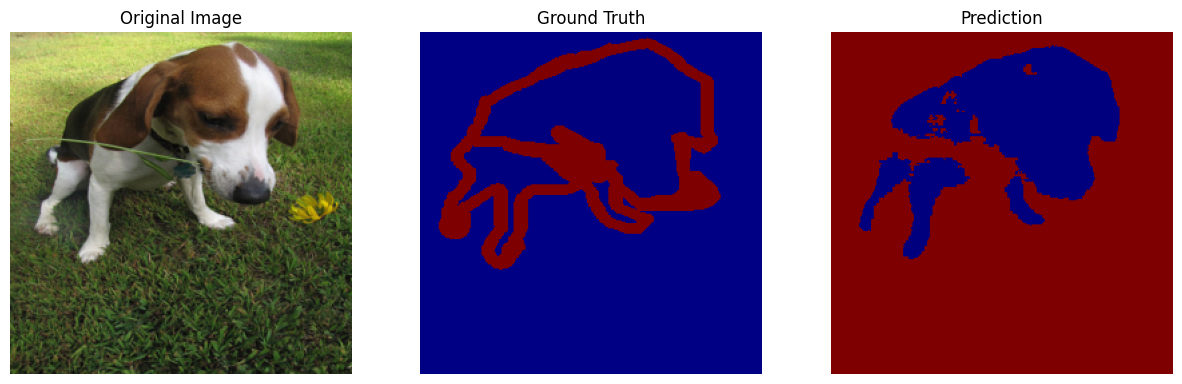

In [47]:
visualize_prediction(model, val_dataset, device)

In [95]:
def visualize_with_overlay(model, dataset, device, idx=None):
    model.eval()

    if idx is None:
        idx = np.random.randint(0, len(dataset))

    image, mask = dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu()

    image_np = image.permute(1, 2, 0).cpu().numpy()
    pred_np = pred.numpy()

    plt.figure(figsize=(6,6))
    plt.imshow(image_np)
    plt.imshow(pred_np, alpha=0.5, cmap="jet")
    plt.axis("off")
    plt.savefig(f"pred_overlay.png", bbox_inches=None, pad_inches=0)
    plt.show()


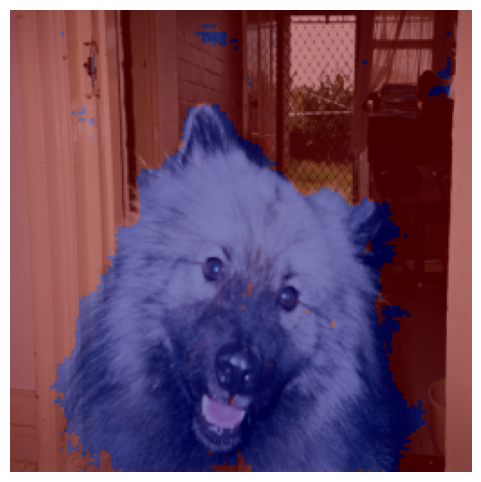

In [146]:
visualize_with_overlay(model, val_dataset, device)

In [92]:
import os
import imageio
from PIL import Image, ImageDraw, ImageFont

frame_folder = "examples_overlay"
frame_files = sorted([f for f in os.listdir(frame_folder) if f.endswith(".png")])

labels = ["Example 1: Dog", "Example 2: Dog", "Example 3: Cat", "Example 4: Dog", "Example 5: Cat"]

frames = []
for i, file in enumerate(frame_files):
    path = os.path.join(frame_folder, file)
    img = Image.open(path).convert("RGBA")

    txt_layer = Image.new("RGBA", img.size, (255,255,255,0))
    draw = ImageDraw.Draw(txt_layer)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    text = labels[i]
    bbox = draw.textbbox((0,0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    x = (img.width - text_width) // 2
    y = img.height - text_height - 5
    draw.text((x, y), text, font=font, fill=(255,255,255,255))

    combined = Image.alpha_composite(img, txt_layer)
    frames.append(combined.convert("RGBA"))  # сохраняем прозрачность в GIF

gif_path = "../notebooks1/segmentation_demo1.gif"
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=1200,
    loop=0
)

print(f"GIF saved to {gif_path}")

GIF saved to segmentation_demo1.gif
